### Importing Necessary Libraries

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
from torch.optim import Adam

from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
from torchsummary import summary

In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter


### Making the code resuable

In [ ]:
#torch.manual_seed(42)
torch.cuda.manual_seed(42)  # If using CUDA
np.random.seed(42)

### Check if CUDA is avialable

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device} ')

Using device: cuda 


### Lets perform Data Transformations for Training: Agumentation and Normalization

In [ ]:
train_transforms = transforms.Compose([
            transforms.Resize((224,224)),  # resizing
            transforms.RandomHorizontalFlip(0.9),  # horizontal flip 0.9%
            transforms.RandomVerticalFlip(),  # vertical flip
            transforms.RandomRotation(90),  # rotaion 90 degree
            transforms.RandomAffine(90, (0.3, 0.3), (1.0, 2.0)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

In [ ]:
val_test_transforms = transforms.Compose([
                      transforms.Resize((224,224)),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Lets Connect it with google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Dont click again

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/OpenCV_working_with_Img/Plant Village/Plant Leaf Diseases.zip" -d "/content/drive/MyDrive/Colab Notebooks/OpenCV_working_with_Img/Plant Village/Plant_Leaf_Diseases"


Archive:  /content/drive/MyDrive/Colab Notebooks/OpenCV_working_with_Img/Plant Village/Plant Leaf Diseases.zip
  inflating: /content/drive/MyDrive/Colab Notebooks/OpenCV_working_with_Img/Plant Village/Plant_Leaf_Diseases/Data for Identification of Plant Leaf Diseases Using a 9-layer Deep Convolutional Neural Network/Plant_leaf_diseases_dataset_without_augmentation.zip  
  inflating: /content/drive/MyDrive/Colab Notebooks/OpenCV_working_with_Img/Plant Village/Plant_Leaf_Diseases/Data for Identification of Plant Leaf Diseases Using a 9-layer Deep Convolutional Neural Network/Plant_leaf_diseases_dataset_with_augmentation.zip  


In [ ]:
# Set paths to the inner ZIP files
base_path = "/content/drive/MyDrive/Colab Notebooks/OpenCV_working_with_Img/Plant Village/Plant_Leaf_Diseases/Data for Identification of Plant Leaf Diseases Using a 9-layer Deep Convolutional Neural Network"

inner_zip_1 = f"{base_path}/Plant_leaf_diseases_dataset_without_augmentation.zip"

# Unzip them to separate folders
!unzip -q "{inner_zip_1}" -d "{base_path}/without_augmentation"

print("Both inner ZIP files extracted!")


Both inner ZIP files extracted!


### Lets begin the real work

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/OpenCV_working_with_Img/Plant Village/Plant_Leaf_Diseases/Data for Identification of Plant Leaf Diseases Using a 9-layer Deep Convolutional Neural Network/without_augmentation/Plant_leave_diseases_dataset_without_augmentation'
dataset = datasets.ImageFolder(root=data_dir, transform=val_test_transforms)

In [ ]:
# Lets get class names and number of class as we it should be 39 for Plant Village
class_names = dataset.classes
num_classes = len(class_names)
print(f'Number of classes: {num_classes}')
print(f'Classes: {class_names}')

Number of classes: 39
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'T

In [ ]:
# lets split Plant Village in Train, Val and Test
# Train -> 70%   Val -> 8%  Test -> 12%
indices = list(range(len(dataset)))
labels = [dataset.targets[i] for i in range(len(dataset))]

# 1st Split  Train(70%) + (Val+Test) (30%)
train_idx, temp_idx, train_labels, temp_labels = train_test_split(indices, labels, test_size=0.3, stratify=labels, random_state=42)

# 2nd Split  Val (15%) + Test (15%) from the 30%
val_idx, test_idx, val_labels, test_labels = train_test_split(temp_idx, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)


In [ ]:
# Now lets create subset of Village Datasets
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

# Apply train transforms to training dataset
train_dataset.dataset.transform = train_transforms


38820
8319
8319


In [ ]:
# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Now lets Visualize Class Distribution

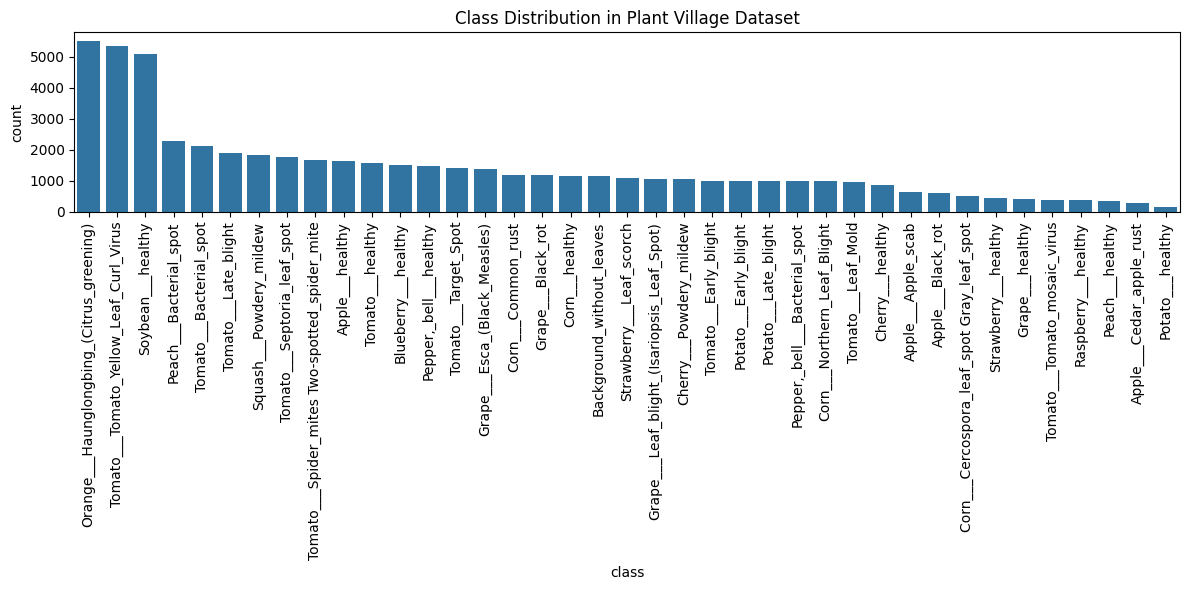

In [ ]:

class_counts = Counter(labels)
class_counts_df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['count'])
class_counts_df['class'] = [class_names[i] for i in class_counts_df.index]
class_counts_df = class_counts_df.sort_values('count', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=class_counts_df, x='class', y='count')
plt.title("Class Distribution in Plant Village Dataset")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
plt.savefig('plnt_vlg_class_distribution.png')
plt.close()

In [ ]:
class GreenCheck(nn.Module):
    def __init__(self, num_classes):
        super(GreenCheck, self).__init__()
        # convolution layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=64*28*28, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # forward pass
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        #print(x.shape)


        #x = x.view(-1, 64 * 28 * 28)
        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
model = GreenCheck(num_classes=num_classes).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

In [ ]:
num_epochs = 15
train_losses, val_losses = [], []
train_accurates, val_accurates = [], []

for epoch in range(num_epochs):
    # Here we train the model
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)


        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accurates.append(train_acc)



    # Lets perform Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accurates.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')


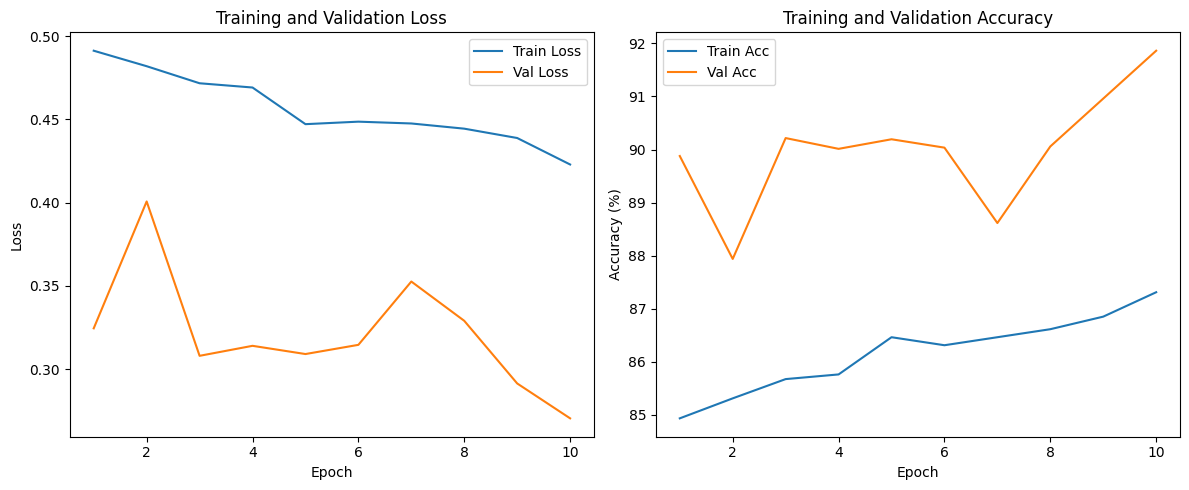

In [ ]:
# Plot Training Metrics
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12,5))

# Loss Plot
plt.subplot(1,2,1)
sns.lineplot(x=epochs, y=train_losses, label='Train Loss')
sns.lineplot(x=epochs, y=val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Accuracy Plot
plt.subplot(1, 2, 2)
sns.lineplot(x=epochs, y=train_accurates, label='Train Acc')
sns.lineplot(x=epochs, y=val_accurates, label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()
plt.savefig('training_metrics.png')
plt.close()

In [ ]:
#  Test Evaluation
model.eval()
test_correct = 0
test_total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * test_correct / test_total
print(f'Test Accuracy: {test_acc:.2f}%')


Test Accuracy: 91.84%


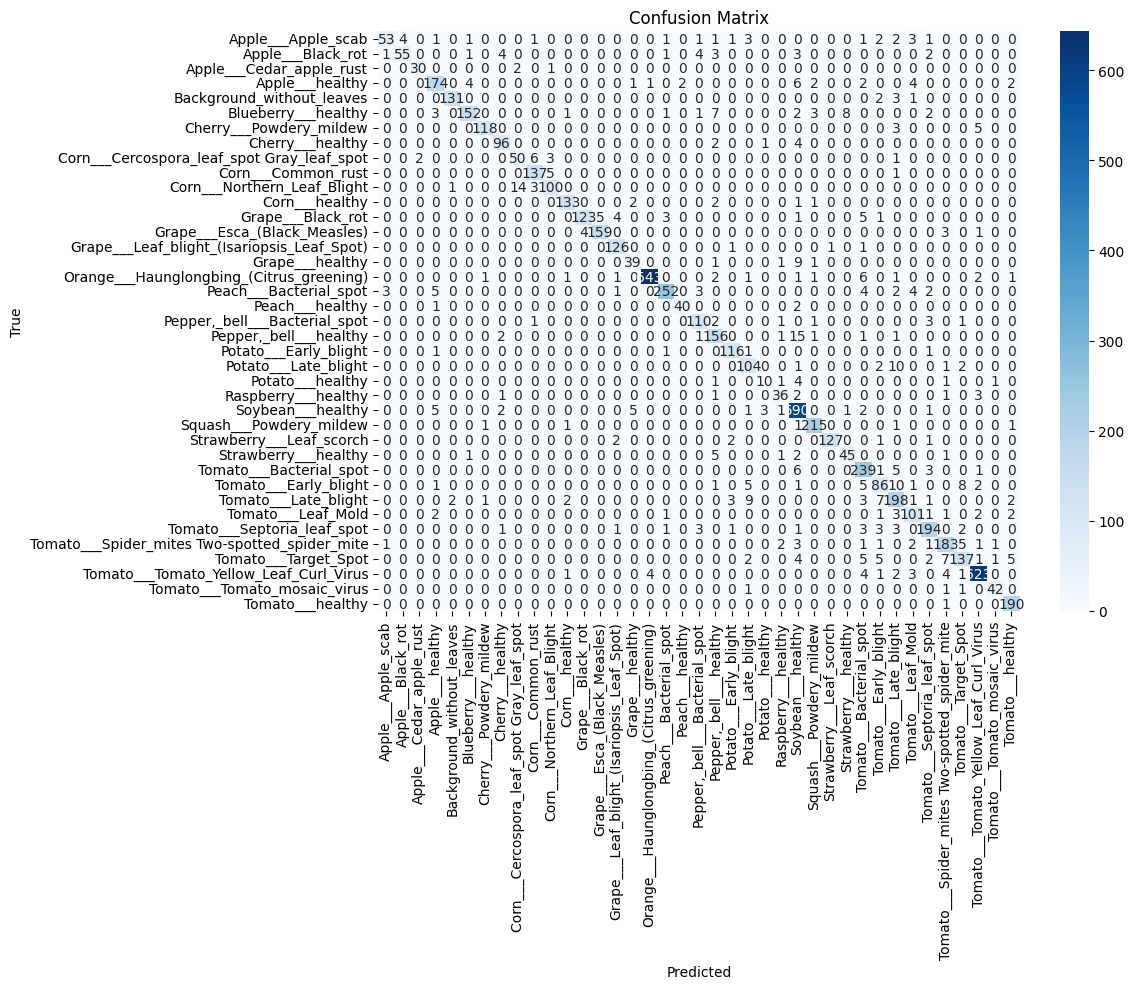

In [ ]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
plt.savefig('confusion_matrix.png')
plt.close()

In [ ]:
# Classification Report
print('\nClassification Report:')
print(classification_report(all_labels, all_preds, target_names=class_names))


Classification Report:
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.91      0.70      0.79        76
                            Apple___Black_rot       0.93      0.74      0.83        74
                     Apple___Cedar_apple_rust       0.94      0.91      0.92        33
                              Apple___healthy       0.90      0.88      0.89       198
                    Background_without_leaves       0.98      0.96      0.97       137
                          Blueberry___healthy       0.96      0.84      0.90       180
                      Cherry___Powdery_mildew       0.98      0.94      0.96       126
                             Cherry___healthy       0.91      0.93      0.92       103
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.76      0.81      0.78        62
                           Corn___Common_rust       0.93      0.96      0.94       143
                  

In [ ]:
# Now We Save the model
torch.save(model.state_dict(), 'plant_village_model.pth')
print('Model saved as plant_village_model.pth')

Model saved as plant_village_model.pth
